Andrew Sheridan 

Summer 2018 Parsons Lab ML Internship

Can we apply machine learning to redundant calibration?

In [2]:
## imports

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter

import sys, os, io
import random

# HERA
import pyuvdata
import hera_cal as hc
import uvtools

***
## Redundant Calibration

In general we are trying to solve an overdetermined system of equations, $\text{A}\bf{x} = \bf{y}$.

 - Each row in the matrix $\text{A}$ is derived from ratios of redundant visiblities, such that the elements of $\text{A}$ are integers representing the antennas used in that ratio

 - the vector $\bf{y}$ contains the sum of the antenna cable delays for that visibility ratio

 - the solution $\bf{x}$ will provide the cable delay for each antenna

\begin{equation}
\begin{bmatrix} 
1 & -2 & 1 & 0 & 0 & 0 & 0 & \cdots& \cdots\\ 
1 & -1 & -1 & 1 & 0 & 0 & 0 & \cdots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots& \ddots\\ 
\end{bmatrix}
\begin{bmatrix} 
\tau_1 \\ \tau_2 \\ \tau_3 \\ \tau_4 \\ \tau_5 \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} =
\begin{bmatrix} 
134\text{ns} \\ 78\text{ns} \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} \rightarrow \text{A}\bf{x} = \bf{y}
\end{equation}

Where in the example the first and second rows of $\text{A}$ are made from these visibilities:
\begin{align}
\frac{V_{12}}{V_{23}} &\leadsto 1\tau_1 -2\tau_2  + 1\tau_3 \rightarrow A_1\\
\frac{V_{12}}{V_{34}} &\leadsto 1\tau_1 -1\tau_2  - 1\tau_3 + 1\tau_4 \rightarrow A_2\\
\end{align} 

 - first goal is to find $\bf{y}$

***
## Wrap / Unwrap problem

For some complex data the slope of the unwrapped phase angle is the delay we wish to find.

 - for perfect data finding the slope is no problem as we can simply unwrap the data.

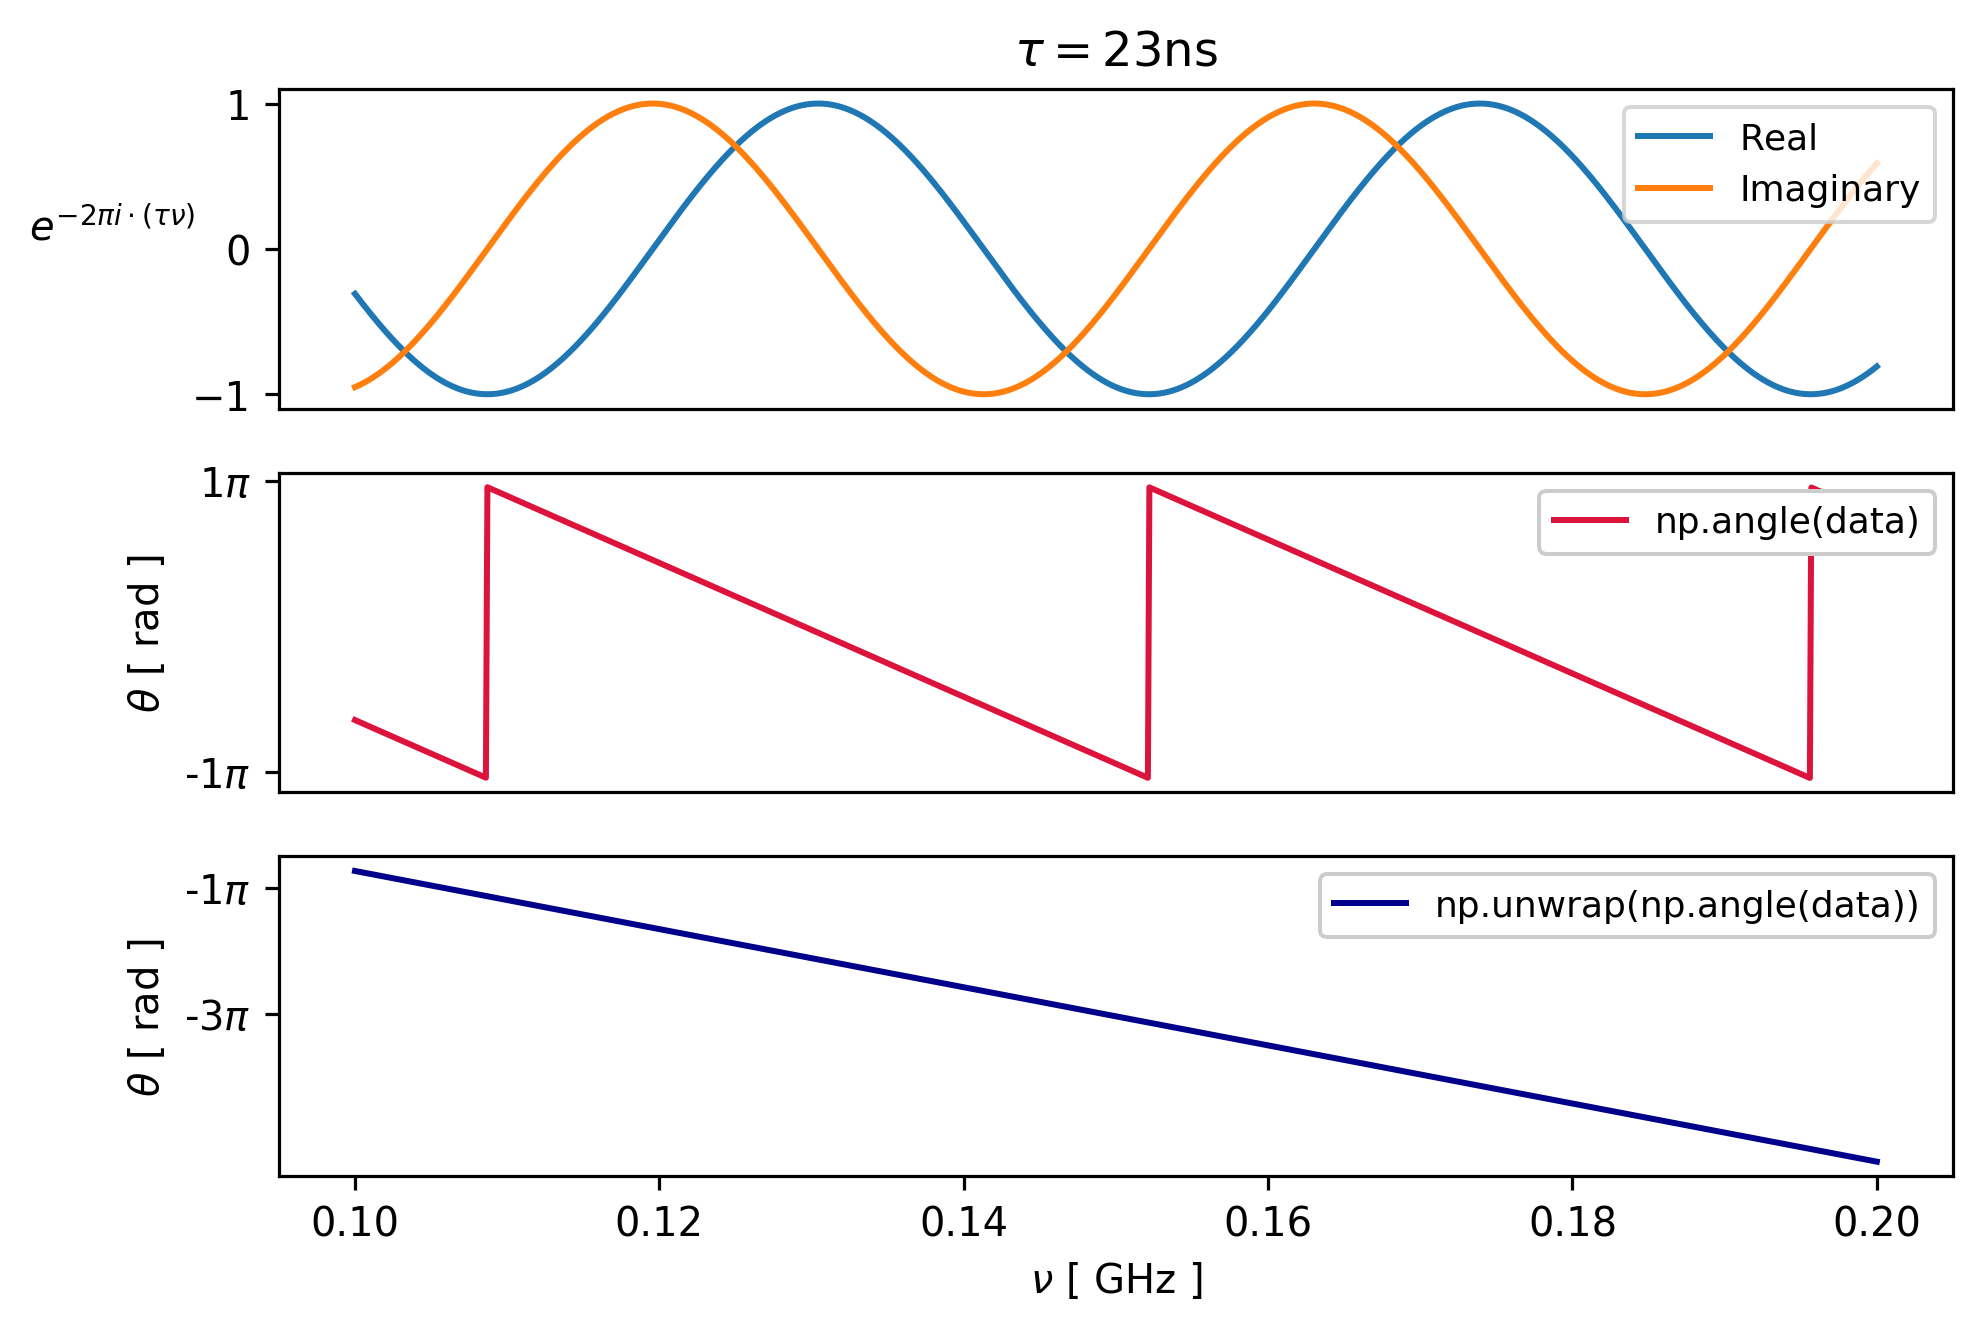

In [3]:
# frequency channels for all data
freqs = np.linspace(0.1, 0.2, 1024) # GHz

# some arbitrary generated data
tau = 23 #ns
phi = 0.0
data = np.exp(-2 * np.pi * 1j * (tau * freqs + phi))
angle_data = np.angle(data)
uw_angle_data = np.unwrap(angle_data)

# plot of data
fig, axes = plt.subplots(3,1, figsize = (7.5, 5), dpi = 144)
ax = axes[0]
ax.plot(freqs, np.real(data), label = 'Real')
ax.plot(freqs, np.imag(data), label = 'Imaginary')

ax.legend(fontsize = 9, loc = 'upper right')
ax.set_title(r'$\tau = 23$ns')
ax.set_ylabel(r'$e^{-2\pi i \cdot (\tau \nu)}$', rotation = 0, labelpad=20)
ax.set_xticks([])

# plot of angle data
ax = axes[1]
ax.plot(freqs, angle_data,
        color = 'crimson', label = 'np.angle(data)')

ax.legend(fontsize = 9, framealpha = 1, loc = 'upper right')
ax.set_ylabel(r'$\theta$ [ rad ]')
ax.set_xticks([])

# plot of unwrapped angle data
ax = axes[2]
ax.plot(freqs, uw_angle_data,
        color = 'darkblue', label = 'np.unwrap(np.angle(data))')

ax.legend(fontsize = 9, framealpha = 1, loc = 'upper right')
ax.set_ylabel(r'$\theta$ [ rad ]')
ax.set_xlabel(r'$\nu$ [ GHz ]')


for ax in axes.reshape(-1)[1:]:
    ymax = int(np.pi + 2 * np.pi * round(float(np.ceil(ax.get_ylim()[1]))/(2 * np.pi)))
    ymin = int(np.pi * round(float(np.floor(ax.get_ylim()[0]))/(2 * np.pi)))
    ax.set_yticks(np.arange(ymin, ymax, np.pi)[::2])
    ax.set_yticklabels([r"{}$\pi$".format(int(round(value / np.pi))) for value in ax.get_yticks()])
    
plt.show()

Problem: our data is not clean and noise disrupts the unrwap function.

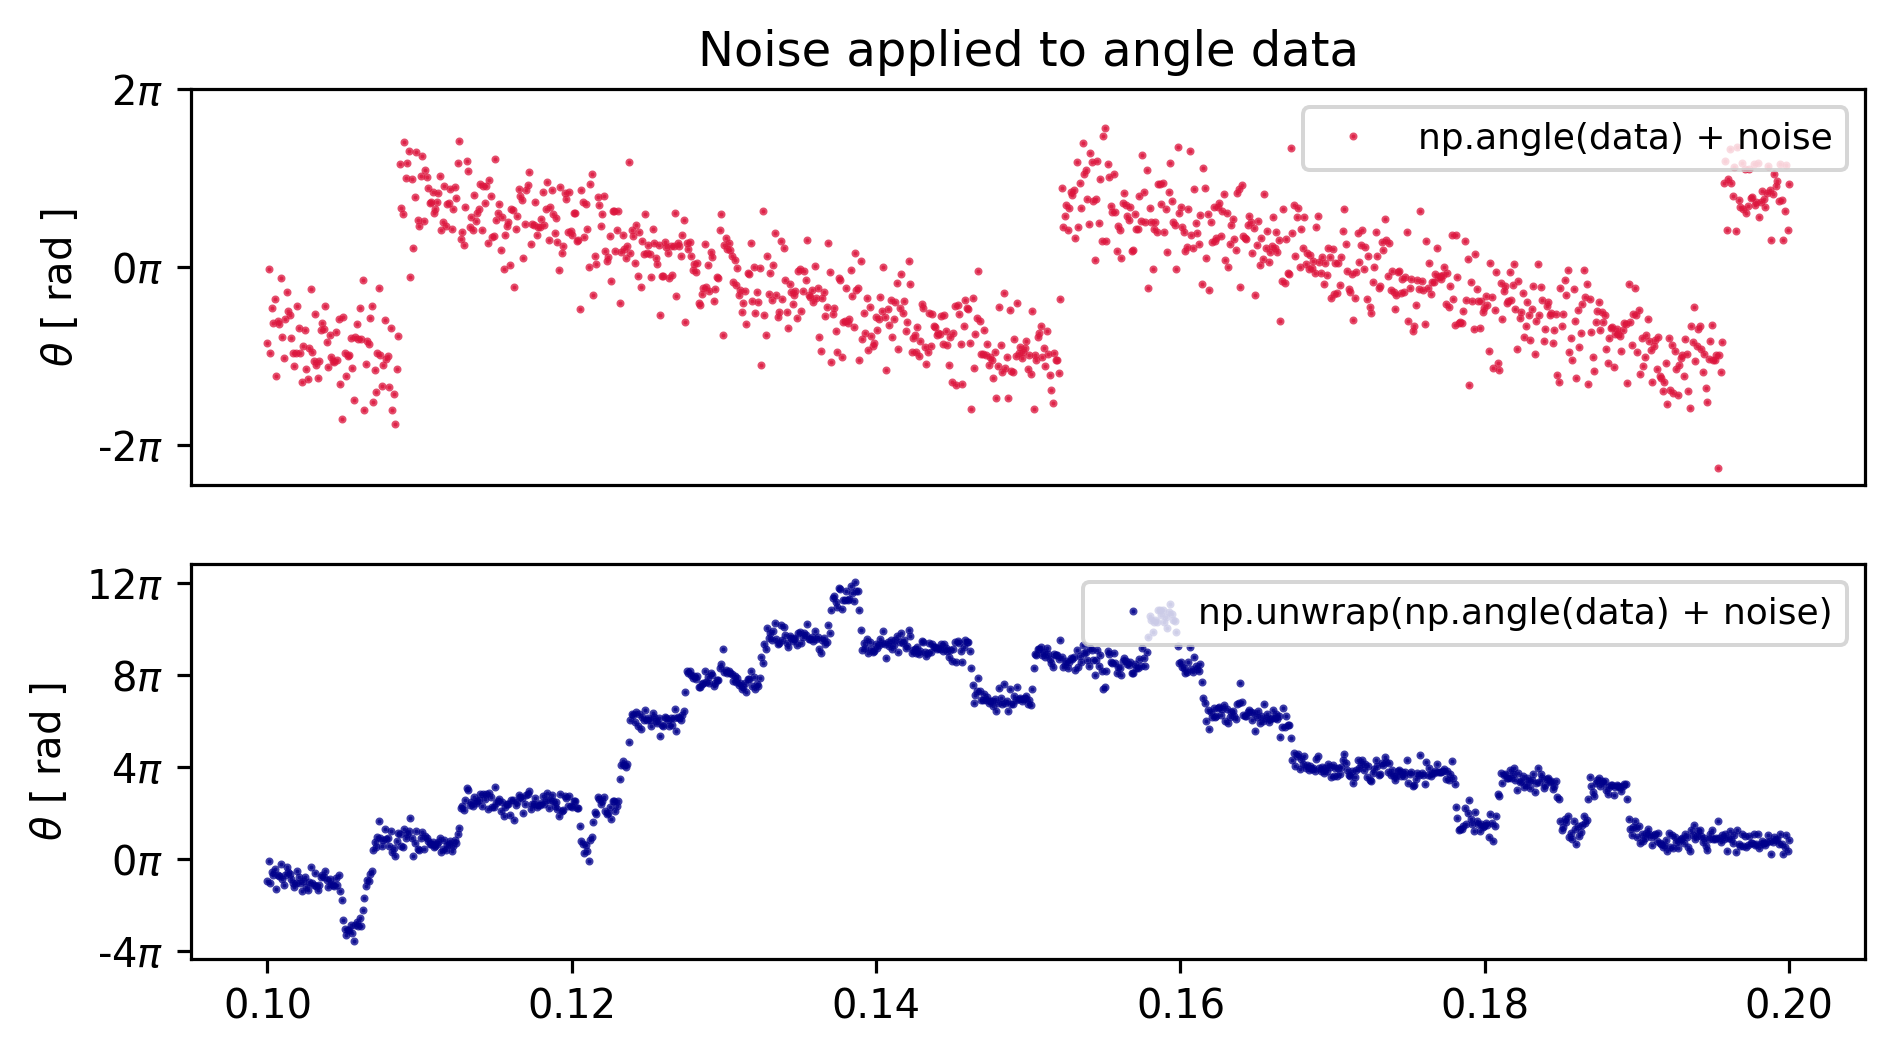

In [4]:
# Noise applied to wrapped data
noisey_angle_data = np.angle(data) + np.random.normal(size = len(data))

# plot of noisey angle data
fig, axes = plt.subplots(2,1, figsize = (7.5, 4), dpi = 144)

ax = axes[0]
ax.set_title('Noise applied to angle data')
ax.plot(freqs, noisey_angle_data,
        linestyle = 'none', marker = 'o', markersize = 1, alpha = 0.75,
        color = 'crimson', label = r'np.angle(data) + noise')
ax.set_xticks([])
ax.legend(fontsize = 9, loc = 'upper right')

ax = axes[1]
ax.plot(freqs, np.unwrap(noisey_angle_data), 
        linestyle = 'none', marker = 'o', markersize = 1, alpha = 0.75,
        color = 'darkblue', label = 'np.unwrap(np.angle(data) + noise)')

ax.legend(fontsize = 9, loc = 'upper right')

for ax in axes.reshape(-1):
    ymax = int(2 * np.pi + 2 * np.pi * round(float(np.ceil(ax.get_ylim()[1]))/(2 * np.pi)))
    ymin = int(2 * np.pi * round(float(np.floor(ax.get_ylim()[0]))/(2 * np.pi)))
    yticks = np.arange(ymin, ymax, np.pi)[::2]
    if len(yticks) > 6:
        yticks = yticks[::2]
    ax.set_yticks(yticks)
    ax.set_yticklabels([r"{}$\pi$".format(int(round(value / np.pi))) for value in ax.get_yticks()])
    ax.set_ylabel(r'$\theta$ [ rad ]')

plt.show()

Can we train a network to find the delay anyway?

### Unitless

To remove units from our work we convert the range of frequencies channels from 1024 channels spanning $0.100$ GHz to just an array of 1024 channels `np.arange(1024)`.

This means that a cable delay of $100$ ns is represented here as a unitless number of around $0.0100$


***

***
## Proof of concept network

Initially we want to ensure that this is works at all, so we attempt to create a network that can compute the delay for data with no noise.

We create a network in TensorFlow that is made of a series of fully connected layers.

![Intial](net1.png)

 - Each input sample is a an array for a single time that is 1024 channels wide.

 - For each input sample the network makes a prediction of its delay.

 - Using a Mean Squared Error cost function this network converges in about 50 epochs.

#### Input Samples

Each input sample we feed to the network has a random delay in the range (-0.010, 0.010) with a random shift applied, and looks like this:

In [46]:
nu = np.arange(1024)

def clean_phase(num_entries = 10000, tau_low = -0.010, tau_high = 0.010):
    """For inital training"""
    num_channels = 1024
    tau = np.random.uniform(low = tau_low, high = tau_high, size = num_entries) 
    phi = np.random.uniform(low = 0, high = 2*np.pi, size =  num_entries)
    
    clean_phase_data = np.empty((num_entries, num_channels))
    for i in range(num_entries):
        clean_phase_data[i] = np.angle(np.exp(-2*np.pi*1j * (tau[i]*nu + phi[i])))
    
    return tau.reshape(-1, 1), clean_phase_data

One sample of 1024 channels:

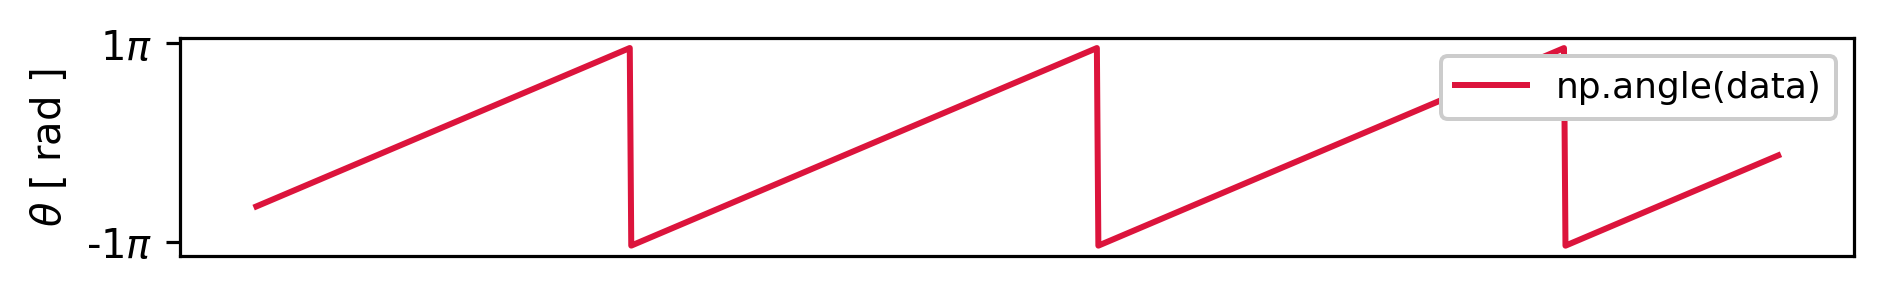

In [54]:
_, inputs = clean_phase(num_entries = 1)

# plot of data
fig, ax = plt.subplots(figsize = (7.5, 1), dpi = 144)
# plot of angle data

ax.plot(nu, inputs.reshape(-1),
        color = 'crimson', label = 'np.angle(data)')

ax.legend(fontsize = 9, framealpha = 1, loc = 'upper right')
ax.set_ylabel(r'$\theta$ [ rad ]')
ax.set_xticks([])

ymax = int(np.pi + 2 * np.pi * round(float(np.ceil(ax.get_ylim()[1]))/(2 * np.pi)))
ymin = int(np.pi * round(float(np.floor(ax.get_ylim()[0]))/(2 * np.pi)))
ax.set_yticks(np.arange(ymin, ymax, np.pi)[::2])
ax.set_yticklabels([r"{}$\pi$".format(int(round(value / np.pi))) for value in ax.get_yticks()])
    
plt.show()

Ten samples:

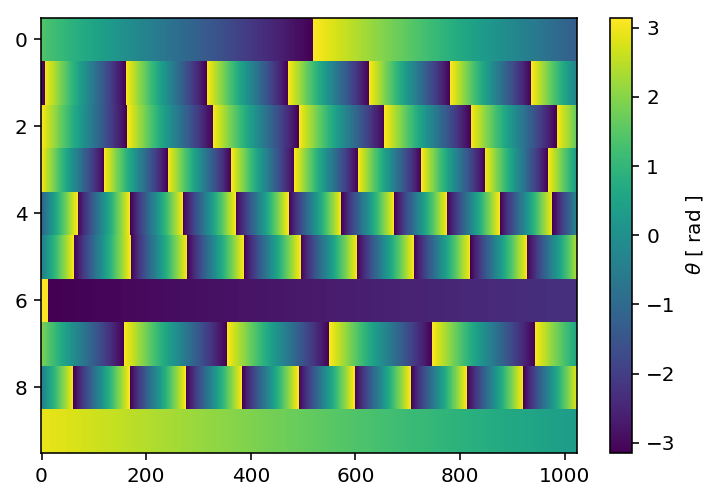

In [82]:
_, inputs = clean_phase(num_entries = 10)

fig, ax = plt.subplots()
im = ax.imshow(inputs, aspect = 'auto')
cbar = fig.colorbar(im)
cbar.set_label(r'$\theta$ [ rad ]')

plt.show()

And we feed the data in in blocks of 10000 samples:

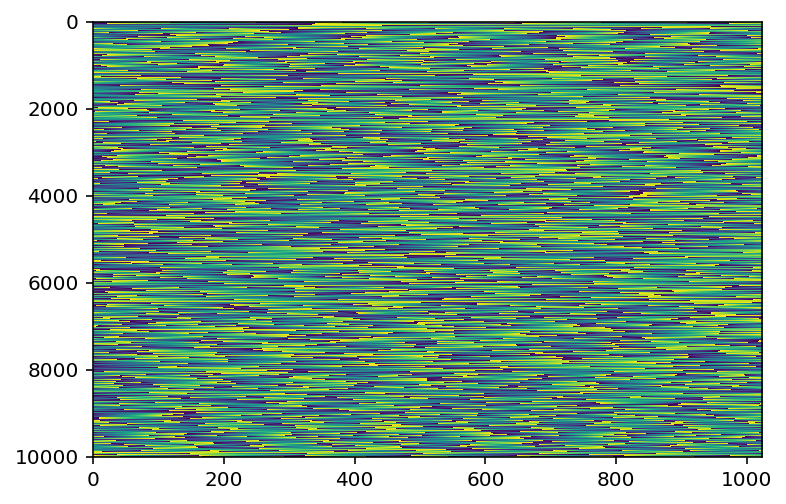

In [57]:
_, inputs = clean_phase(num_entries = 10000)

plt.imshow(inputs, aspect = 'auto')

In [ ]:
# data scaling
def delay_tx(delay, min_d = -0.040, max_d = 0.040):
    return (delay + abs(min_d)) / (abs(max_d) + abs(min_d))

def delay_itx(scaled_delay, min_d = -0.040, max_d = 0.040):
    
    return scaled_delay*(abs(max_d) + abs(min_d)) - abs(min_d)

def angle_tx(angles):
    return (angles + np.pi) / (2 * np.pi)

def angle_itx(scaled_angles):
    return scaled_angles*2.*np.pi - np.pi

Each row in the input dataset is processed down to a single numerical prediction of the $\tau$ for that row. The number and size of the layers was found via trial and error.

The NN class below takes in a list of layer dimensions and generates a network as above. Various versions of this design we used.

In [ ]:
class NN(object):
    """A neural network of fully connected ReLU layers. Dropout between input layer and first hidden layer. """
    
    def __init__(self,
                 layer_nodes,
                 number_of_inputs,
                 number_of_outputs,
                 learning_rate,
                 sigma = 0.0025):
        
        tf.reset_default_graph()
        
        with tf.variable_scope('input'):
            self.X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs), name = 'X')
    
        with tf.variable_scope('targets'):
            self.targets  = tf.placeholder(tf.float32, shape = (None, 1), name = 'targets')
            
        with tf.variable_scope('keep_prob'):
            self.keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')
            
            
        #################### Layers
            
        layers = []
        with tf.variable_scope('dropout'):
            dropout = tf.nn.dropout(self.X, self.keep_prob)            
            layers.append(dropout)
            
        with tf.variable_scope('input_layer'):
            b = tf.get_variable(name = 'bias',
                                shape = [layer_nodes[0]],
                                initializer = tf.zeros_initializer())
            
            w = tf.get_variable(name = 'weights',
                                shape  = [number_of_inputs, layer_nodes[0]],
                                initializer = tf.contrib.layers.xavier_initializer())
            
            layer = tf.nn.leaky_relu(tf.matmul(layers[0], w) + b)
            layers.append(layer)
            
        for i in range(len(layer_nodes)):
            if i > 0:
                with tf.variable_scope('layer_%d' %(i)):
                    b = tf.get_variable(name = 'bias',
                                        shape = [layer_nodes[i]],
                                        initializer = tf.zeros_initializer())
                    
                    w = tf.get_variable(name = 'weights',
                                        shape  = [layer_nodes[i-1], layer_nodes[i]],
                                        initializer = tf.contrib.layers.xavier_initializer())
                    
                    layer = tf.nn.relu(tf.matmul(layers[i], w) + b)
                    layers.append(layer)
                    
        #################### evaluation            
                
        with tf.variable_scope('prediction'):
            b = tf.get_variable(name = 'bias',
                                shape = [number_of_outputs],
                                initializer = tf.zeros_initializer())
            
            w = tf.get_variable(name = 'weights',
                                shape  = [layer_nodes[-1], number_of_outputs],
                                initializer = tf.contrib.layers.xavier_initializer())
            
            self.prediction = tf.nn.relu6(tf.matmul(layers[-1], w) + b)
            self.error = tf.subtract(self.prediction, self.targets, name = 'difference')
            
        with tf.variable_scope('costs'):

            with tf.variable_scope('normal_distribution'):
                self.sigma = sigma
                self.normal_dist = tf.contrib.distributions.Normal(0.0, self.sigma, name = 'normal_dist')
                self.gaussian_prob = self.normal_dist.prob(self.error, name = 'gaussian_prob')
                self.shifted_gaussian = tf.add(self.gaussian_prob, 1.0, name = 'shifted_gaussian')        

            with tf.variable_scope('mean_inverse_shifted_gaussian'):
                self.mean_inverse_shifted_gaussian = tf.reduce_mean(tf.divide(1.0, self.shifted_gaussian), name = 'mean_inverse_shifted_gaussian')

            self.squared_error = tf.square(self.error, name = 'squared_error')

            with tf.variable_scope('combined_cost'):
                self.combined_cost = tf.reduce_mean(tf.divide(self.squared_error, self.shifted_gaussian), name = 'combined_cost')

            with tf.variable_scope('mean_squared_error'):
                self.mean_squared_error = tf.reduce_mean(self.squared_error)
                
                
        #################### Training        

        with tf.variable_scope('train'):

            self.optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(self.combined_cost)
            
            
        #################### Log    
            
        with tf.variable_scope('image'):
            self.image_buf = tf.placeholder(tf.string, shape=[])
            epoch_image = tf.expand_dims(tf.image.decode_png(self.image_buf, channels=4), 0)

        with tf.variable_scope('logging'):  

            tf.summary.histogram(name = 'targets', values = self.targets)
            tf.summary.histogram(name = 'predictions',values =  self.prediction)
            tf.summary.scalar(name = 'MSD', tensor = self.mean_squared_error)
            tf.summary.scalar(name = 'MISGC', tensor = self.mean_inverse_shifted_gaussian)
            tf.summary.scalar(name = 'CC', tensor = self.combined_cost)
            tf.summary.image('prediction_vs_actual', epoch_image)
            self.summary = tf.summary.merge_all()    



### Cost Functions

Various cost functions were trialed. The Mean Squared Error:
\begin{equation}
\text{MSE} = \langle(\text{targets} - \text{predictions})^2\rangle
\end{equation}

 - Works reasonable well but did a poor of bringing the values within the threshold we had set (5ns).

Aaron suggested we try a Gaussian Cost function 

\begin{equation}
\text{GC} = \text{Normal Distribution(}\mu = 0, \sigma = \sigma, x = (\text{targets} - \text{predictions})\text{)}
\end{equation}

 -  performed poorly, in fact it did the opposite of what we wanted  and carved out a zone near the targets that the predictions would avoid.

So we inverted it and added a shift to prevent divide by zero errors. The Mean Inverse Shifted Gausian:

\begin{equation}
\text{MISG} = \bigg\langle\frac{1}{\text{shift} + \text{GC}}\bigg\rangle
\end{equation}

### How did the proof of concept network perform?

Each epoch a dataset of 10000 entries is generated, 8000 are used for training, 2000 for testing.

- This is an animation of the predictions vs the targets for the testing datasets.

  -  x-axis notes the entry number
  - the y axis represents the unitless delays.
  - Red dots are the target delay values
  -  blue dots are the predicted delay values.
  - The title is the standard deviation of the error. 

![DelilahA](Delilah-run-A_testing_1528752871.gif)

The proof of concept works.

### More realistic data

Will the network learn on data that is not clean?

Using real data from `zen.2458098.58037.xx.HH.uv` we create new training data.

 - We combine redundant visibilities and their gains to create a *flatness*
  - We apply a known delay to that flatness.
  
A flatness $S$ is a ratio of redundant visibilities times their gains, which we compute as a product:

\begin{equation}
S = V_{ij}g_i^* g_jV_{kl}^*g_k g_l^*
\end{equation}

In [9]:
# load in data for a JD. 
data_directory = '../zen_data/'
miriad_path = data_directory + 'zen.2458098.58037.xx.HH.uv'

uvd = pyuvdata.UVData()
uvd.read_miriad(miriad_path)

# get the redundancies for that data
aa = hc.utils.get_aa_from_uv(uvd)
info = hc.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())

# gains for same data 
calfits_path = data_directory + 'zen.2458098.58037.xx.HH.uv.abs.calfits'
gains, flags = hc.io.load_cal(calfits_path)
gains_c = {key : gains[key].conjugate() for key in gains.keys()}

def ants_good(bl, gain_keys):
    """Returns True if BOTH antennas from bl are in gain_keys."""
    ants = [a[0] for a in gain_keys] 
    if bl[0] in ants and bl[1] in ants:
        return True
    else:
        return False

def elemental_baselines(red_bls):
    bls = []
    for sublist in sorted(red_bls):
        bls.append(sorted(sublist)[0])
    return sorted(bls)

def good_redundant_baselines_dict(good_redundant_baselines, elemental_baselines):
    bls_dict = {}
    for sublist in good_redundant_baselines:
        for elemental in elemental_baselines:
            if elemental in sublist:
                bls_dict[elemental] = sorted(sublist)
                break
    return bls_dict

# run ONCE

# # eliminate baselines that are made up of only bad antennas
# # Also we need at least two baselines per group
# good_redundant_baselines = []
# for group in red_bls:
#     new_group = []
#     for bl in group:
#         if ants_good(bl, gains.keys()) == True:
#             new_group.append(bl)
#     if len(new_group) > 1:
#         good_redundant_baselines.append(new_group)

# training_percent = 0.80
# training_redundant_baselines, testing_redundant_baselines = np.split(np.random.permutation(good_redundant_baselines),
#                                                                      [int(len(good_redundant_baselines)*training_percent)])
# np.savez('training_redundant_baselines', training_redundant_baselines)
# np.savez('testing_redundant_baselines', testing_redundant_baselines)

from numpy import load
def loadnpz(filename):
    a = load(filename)
    d = dict(zip(("data1{}".format(k) for k in a), (a[k] for k in a)))
    return d['data1arr_0']

training_redundant_baselines = loadnpz('training_redundant_baselines.npz')
testing_redundant_baselines = loadnpz('testing_redundant_baselines.npz')

# list of the elemental baseline for each group
training_elemental_baselines = elemental_baselines(training_redundant_baselines)
testing_elemental_baselines = elemental_baselines(testing_redundant_baselines)

# dictionaries of the baseline groups, keys are elemental baselines
training_baselines_dict = good_redundant_baselines_dict(training_redundant_baselines, training_elemental_baselines)
testing_baselines_dict = good_redundant_baselines_dict(testing_redundant_baselines, testing_elemental_baselines)

# baselines as keys
training_baselines_data = {}
for elemental in training_elemental_baselines:
    for bl in training_baselines_dict[elemental]:
        training_baselines_data[bl] = uvd.get_data(bl)

training_baselines_data_c = {key : training_baselines_data[key].conjugate() for key in training_baselines_data.keys()}

testing_baselines_data = {}
for elemental in testing_elemental_baselines:
    for bl in testing_baselines_dict[elemental]:
        testing_baselines_data[bl] = uvd.get_data(bl)
        
testing_baselines_data_c = {key : testing_baselines_data[key].conjugate() for key in testing_baselines_data.keys()}

In [10]:
def flatness(baselines, data, data_c):
    """Create a flatness from a given pair of baselines, their data & their gains."""
    
    a, b = baselines[0][0], baselines[0][1]
    c, d = baselines[1][0], baselines[1][1]
 
    return data[baselines[0]]*data_c[baselines[1]] * gains_c[(a,'x')] * gains[(b,'x')] * gains[(c,'x')] * gains_c[(d,'x')]

baseline_group = (1, 37)
baseline_pairs = [(85, 139), (83, 137)]


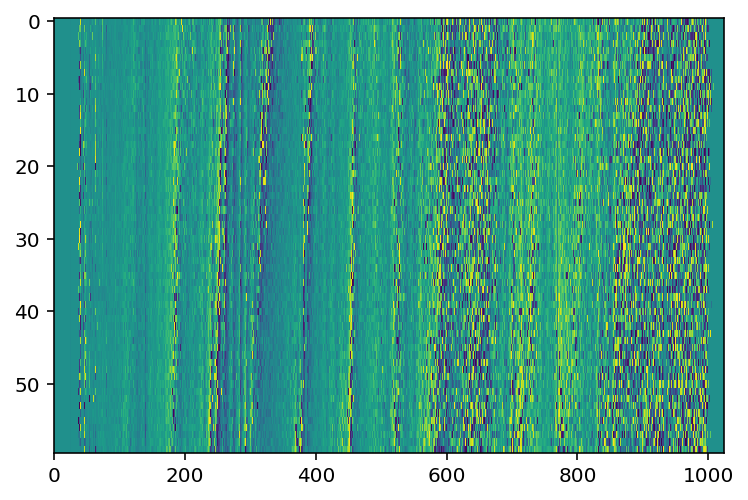

In [11]:
baseline_group = random.sample(training_elemental_baselines, 1)[0]; print('baseline_group = {}'.format(baseline_group))
baseline_pair = random.sample(training_baselines_dict[baseline_group], 2); print('baseline_pairs = {}'.format(baseline_pair))

S = flatness(baseline_pair, training_baselines_data, training_baselines_data_c)

uvtools.plot.waterfall(S, mode = 'phs')
plt.show()

We apply a known unitless delay $\tau$ and random shift $\phi$ to the flatness:

\begin{equation}
S \rightarrow S\cdot\exp{\big(-2\pi i (\tau\nu + \phi)\big)}
\end{equation}

rand_delay = -0.0239258751819


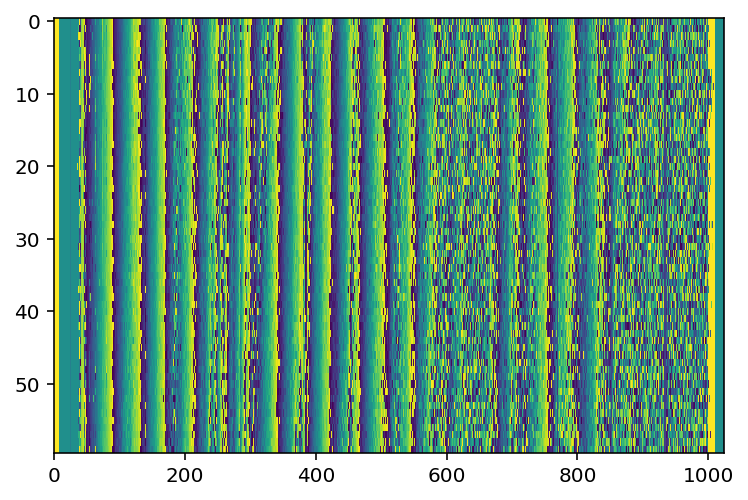

In [13]:
nu = np.arange(1024)
rand_delay = np.random.uniform(-0.040,0.040); print('rand_delay = {}'.format(rand_delay))
single_delay_data = S*np.exp(-2j*np.pi*(rand_delay*nu + np.random.uniform()))

uvtools.plot.waterfall(single_delay_data, mode = 'phs')
plt.show()

Each flatness gives us 60 rows and to increase the amount of delays we send to our netowrk we decide to apply a unique unitless delay to each row.

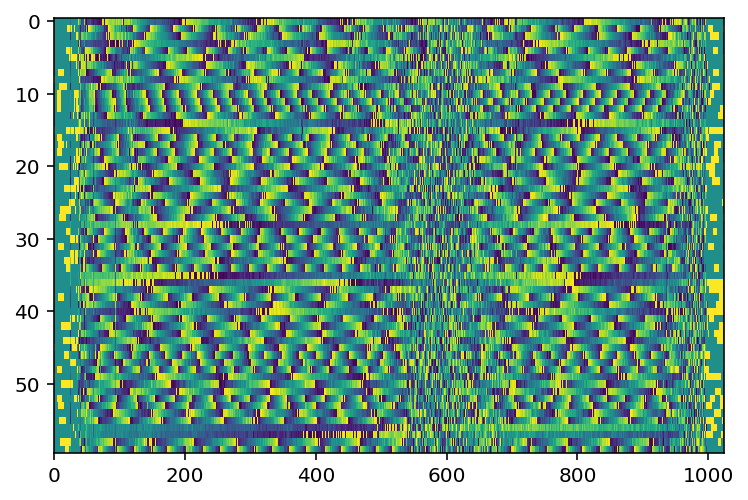

In [122]:
rand_delays = np.random.uniform(-0.040,0.040, size = (60,1))
many_delay_data = S*np.exp(-2j*np.pi*(rand_delays*nu + np.random.uniform()))

uvtools.plot.waterfall(many_delay_data, mode = 'phs')
plt.show()

### Results

After training the network on 20 - 40million samples, it provides decent results.

See `Faora_Results.ipynb`

**Problems**:

 - The X shape that when we used the MISG to optimize reduced the percentage of results in the threshold
 
 - Possible overfitting
 
 - slow

***

### CNN

Alternate Approach with 1-D convolutional network

The new network is somewhat similar to [Googles LeNet](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/googlenet.html)

- A series of multipath layers followed by some fully connected layers.

<img src="FlatNet_2.png" width="400">

Each multipath layer is made from four paths:

 - A downsampling average-pool followed by a 1x1 convolution
 - A 1x1 convolution followed by a 1x"narrow" downsampling convolution
 - A 1x1 convolution followed by a 1x"wide" downsampling convolution
 - A downsampling max-pool followed by a 1x1 convolution

Each path has its own filters. The output of a multipath layer is a concatenated list of the filters.

<img src="FlatNet_2Layer.png">

This network takes in the same type of data as the previous one. Our hope is that it provides better and faster results.

Only finished writing it last night. 

[Current Version](https://github.com/andrewasheridan/hera_sandbox/blob/master/aas/convolutional_network/flat_CNN.ipynb)

Only ran it for a minute to see if it didnt crash:

<img src="FlatNet_2_initial.png" width = "800">

Is there a best practices way to decide on the various network parameters?
 - learning rate
 - cost function
 - batch size
 - number of nodes in fully connected layers
 - size and number of filters for convolutions
 
Are there network designs in general we should look at, or anything else?